In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os
import sys


import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from noslice import *

In [3]:
count = pd.read_csv("./data/GSE147747_expr_raw_counts_table.tsv",
                    sep="\t", index_col=0)

In [4]:
meta = pd.read_csv("./data/GSE147747_meta_table.tsv",
                   sep="\t", index_col=0)

In [5]:
adata_st_all = ad.AnnData(X = count.values)
adata_st_all.obs.index = count.index
adata_st_all.obs = meta.loc[adata_st_all.obs.index]
adata_st_all.var.index = count.columns

slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
 '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
 '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
 '31A', '32A', '33A', '34A', '35A',]

meta_slice = pd.read_csv("./data/figures/slicestable.tsv",
                        index_col=0, sep="\t")

In [6]:
slice_AP = [float(meta_slice.loc[s]['AP']) * 1000 for s in slice_use]
slice_dist_micron = [-(slice_AP[i+1] - slice_AP[i]) for i in range(len(slice_AP)-1)]

adata_st_all = adata_st_all[[s in slice_use for s in adata_st_all.obs.section_index.values]]
sc.pp.filter_cells(adata_st_all, min_genes=1)

adata_st_all.obsm['spatial'] = np.concatenate((adata_st_all.obs['HE_X'].values.reshape(-1, 1),
                                               adata_st_all.obs['HE_Y'].values.reshape(-1, 1)), axis=1)

adata_st_list_raw = []

for slice_id in sorted(set(adata_st_all.obs.section_index.values)):
    adata_st_i = adata_st_all[adata_st_all.obs.section_index.values == slice_id]

    array_col = np.array([np.float_(loc.split("_")[1].split("x")[0]) for loc in adata_st_i.obs.index])
    if slice_id == '01A':
        array_col = array_col - 0.3
    array_row = np.array([np.float_(loc.split("_")[1].split("x")[1]) for loc in adata_st_i.obs.index])

    adata_st_i.obs['array_col'] = np.round(array_col)
    adata_st_i.obs['array_row'] = np.round(array_row)
    adata_st_i.obsm['loc_use'] = np.concatenate((adata_st_i.obs['array_row'].values.reshape(-1, 1),
                                                 adata_st_i.obs['array_col'].values.reshape(-1, 1)), axis=1)

    adata_st_list_raw.append(adata_st_i.copy())

for i in range(1, 6): # adjust spatial locations
    adata_st_list_raw[i].obsm['loc_use'] = np.concatenate((adata_st_list_raw[i].obsm['loc_use'][:, 0].reshape(-1, 1),
                                                           2*np.mean(adata_st_list_raw[i].obsm['loc_use'][:, 1])-adata_st_list_raw[i].obsm['loc_use'][:, 1].reshape(-1, 1)), axis=1)

In [7]:
adata_ref = ad.read_h5ad("./data/MouseBrain/all_cells_20200625.h5ad")
adata_ref.var.index = adata_ref.var["SYMBOL"].astype(str)
adata_ref.var_names_make_unique()
labels = pd.read_csv("./data/MouseBrain/snRNA_annotation_astro_subtypes_refined59_20200823.csv", index_col=0)

labels = labels.reindex(index=adata_ref.obs_names)
adata_ref.obs[labels.columns] = labels
adata_ref = adata_ref[~adata_ref.obs['annotation_1'].isna(), :]
adata_ref.obs['celltype'] = adata_ref.obs['annotation_1']

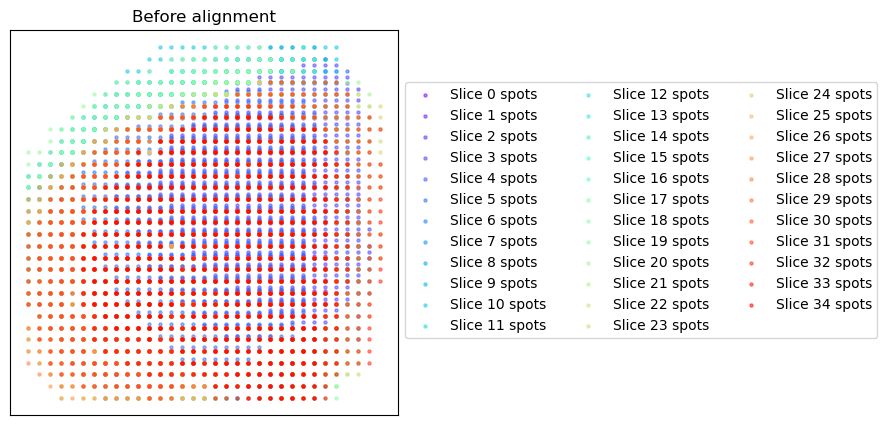

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


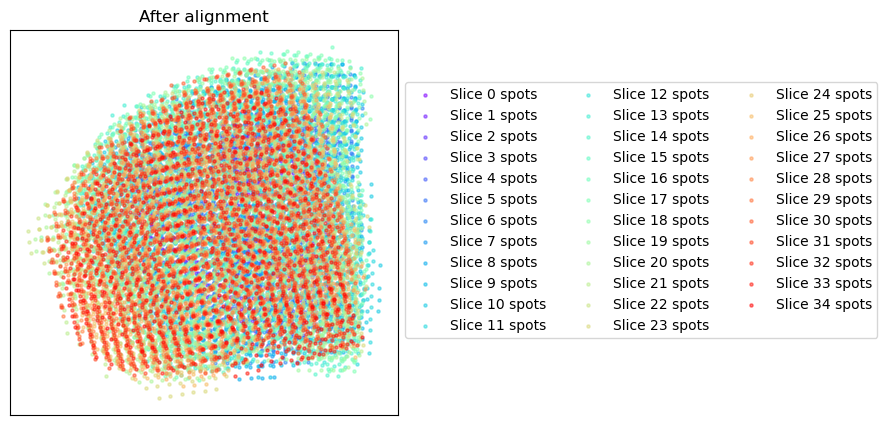

In [8]:
adata_st_list = noslice.utils.align_spots(adata_st_list_raw,
                                           data_type = "ST",
                                           coor_key="loc_use",
                                           plot=True)

In [9]:
adata_st, adata_basis = noslice.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  sample_col="sample",
                                                  coor_key="loc_use",
                                                  slice_dist_micron=slice_dist_micron,
                                                  c2c_dist=200.,
                                                  n_hvg_group=500)

Finding highly variable genes...


KeyboardInterrupt: 

In [9]:
model = noslice.model.Model(adata_st, adata_basis, training_steps = 2000)

model.train(step_interval=100)

NameError: name 'adata_st' is not defined